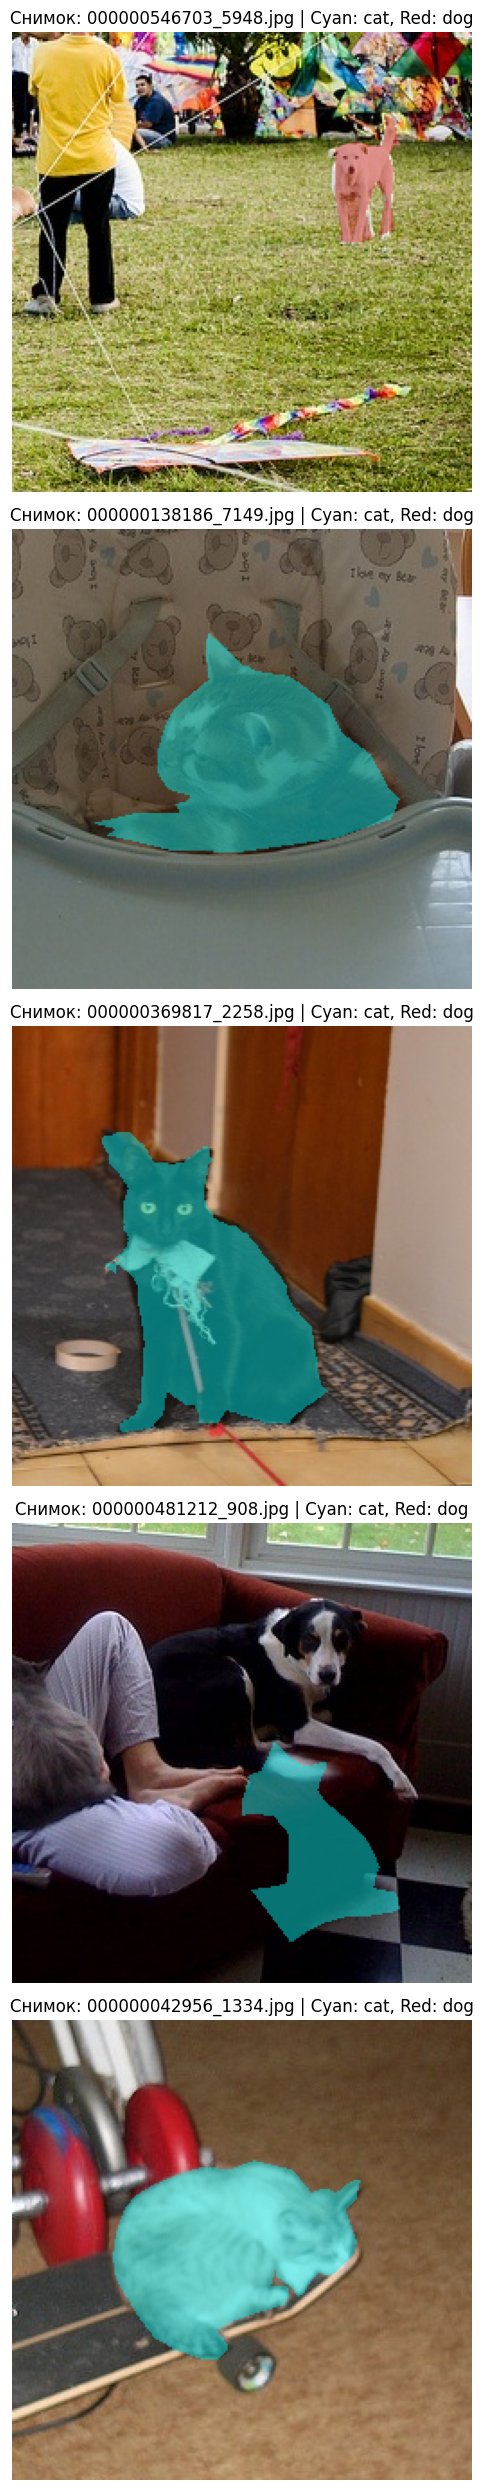

In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Пути к вашему датасету
IMG_DIR = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/images/train'
ANN_DIR = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/annotations/train'

def peek_at_objects(num_samples=5):
    img_files = [f for f in os.listdir(IMG_DIR) if f.endswith(('.jpg', '.png'))]
    samples = random.sample(img_files, min(num_samples, len(img_files)))
    
    # Цвета: 1 - Cyan, 2 - Red
    palette = {1: [6, 230, 230], 2: [200, 50, 50]}
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 5 * num_samples))
    
    for i, name in enumerate(samples):
        img = cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, name)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(ANN_DIR, name.replace('.jpg', '.png')), 0)
        
        overlay = img.copy()
        for val, color in palette.items():
            overlay[mask == val] = color
        
        combined = cv2.addWeighted(img, 0.5, overlay, 0.5, 0)
        axes[i].imshow(combined)
        axes[i].set_title(f"Снимок: {name} | Cyan: cat, Red: dog")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

peek_at_objects()

In [2]:
#  ПОСЛЕ ПРОСМОТРА 
NEW_NAME_1 = "cat"  # вместо object_1 (Cyan)
NEW_NAME_2 = "dog"    # вместо object_2 (Red)
# ---------------------------------------------------

def update_project_files():
    files_to_fix = [
        'E:/Yandex_prakt/mmsegmentation/mmseg/datasets/stud_dataset.py',
        'E:/Yandex_prakt/mmsegmentation/configs/segformer/segformer_b0_custom.py'
    ]
    
    for file_path in files_to_fix:
        if not os.path.exists(file_path):
            print(f"Файл не найден: {file_path}")
            continue
            
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Замена названий
        updated_content = content.replace("'object_1'", f"'{NEW_NAME_1}'")
        updated_content = updated_content.replace("'object_2'", f"'{NEW_NAME_2}'")
        
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(updated_content)
        
        print(f"Успешно обновлен: {file_path}")

update_project_files()

Успешно обновлен: E:/Yandex_prakt/mmsegmentation/mmseg/datasets/stud_dataset.py
Успешно обновлен: E:/Yandex_prakt/mmsegmentation/configs/segformer/segformer_b0_custom.py


In [3]:
import os
from PIL import Image

def cleanup_dataset(data_root):
    splits = ['train', 'val', 'test']
    files_to_delete = []

    print(f"--- НАЧАЛО ОЧИСТКИ ДАТАСЕТА: {data_root} ---")

    for split in splits:
        img_dir = os.path.join(data_root, 'images', split)
        ann_dir = os.path.join(data_root, 'annotations', split)
        
        if not os.path.exists(img_dir):
            continue

        images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for img_name in images:
            img_path = os.path.join(img_dir, img_name)
            ann_name = os.path.splitext(img_name)[0] + '.png'
            ann_path = os.path.join(ann_dir, ann_name)
            
            # 1. Проверка на наличие маски (кроме папки test, если там нет масок)
            if split != 'test' and not os.path.exists(ann_path):
                print(f"[УДАЛЕНИЕ] Отсутствует маска для: {img_name}")
                files_to_delete.append(img_path)
                continue

            try:
                # 2. Проверка на повреждение файла изображения
                with Image.open(img_path) as img_file:
                    img_size = img_file.size
                
                if split != 'test':
                    # 3. Проверка на повреждение файла маски и соответствие размеров
                    with Image.open(ann_path) as ann_file:
                        ann_size = ann_file.size
                    
                    if img_size != ann_size:
                        print(f"[УДАЛЕНИЕ] Размеры не совпадают: {img_name} ({img_size} != {ann_size})")
                        files_to_delete.append(img_path)
                        files_to_delete.append(ann_path)
                        
            except Exception as e:
                print(f"[УДАЛЕНИЕ] Файл поврежден: {img_name}. Ошибка: {e}")
                files_to_delete.append(img_path)
                if os.path.exists(ann_path):
                    files_to_delete.append(ann_path)

    # Итоговое удаление
    if not files_to_delete:
        print("\nБитых или неполных данных не обнаружено.")
    else:
        confirm = input(f"\nНайдено файлов для удаления: {len(files_to_delete)}. Введите 'yes' для удаления: ")
        if confirm.lower() == 'yes':
            for f in files_to_delete:
                if os.path.exists(f):
                    os.remove(f)
            print("Удаление завершено.")
        else:
            print("Удаление отменено.")

# Запуск
cleanup_dataset('E:/Yandex_prakt/1_Proj_segment/stud_dataset/')

--- НАЧАЛО ОЧИСТКИ ДАТАСЕТА: E:/Yandex_prakt/1_Proj_segment/stud_dataset/ ---

Битых или неполных данных не обнаружено.


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown, Button, Output, HBox
from IPython.display import clear_output

# Базовый путь к датасету
DATA_ROOT = 'E:/Yandex_prakt/1_Proj_segment/stud_dataset/'

# Глобальные переменные для хранения состояния
out = Output()

def delete_current_files(split, index):
    """Функция для удаления текущего изображения и его маски"""
    img_dir = os.path.join(DATA_ROOT, 'images', split)
    ann_dir = os.path.join(DATA_ROOT, 'annotations', split)
    
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    if not img_files:
        return

    img_name = img_files[index % len(img_files)]
    img_path = os.path.join(img_dir, img_name)
    ann_path = os.path.join(ann_dir, os.path.splitext(img_name)[0] + '.png')

    with out:
        try:
            if os.path.exists(img_path):
                os.remove(img_path)
                print(f"Удалено изображение: {img_name}")
            if os.path.exists(ann_path):
                os.remove(ann_path)
                print(f"Удалена аннотация: {os.path.basename(ann_path)}")
            print("Обновите слайдер или выберите другой индекс для продолжения.")
        except Exception as e:
            print(f"Ошибка при удалении: {e}")

def show_comparison(split, index):
    with out:
        clear_output(wait=True)
        img_dir = os.path.join(DATA_ROOT, 'images', split)
        ann_dir = os.path.join(DATA_ROOT, 'annotations', split)
        
        img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        
        if not img_files:
            print(f"В папке {split} больше нет изображений.")
            return

        img_name = img_files[index % len(img_files)]
        img_path = os.path.join(img_dir, img_name)
        ann_path = os.path.join(ann_dir, os.path.splitext(img_name)[0] + '.png')
        
        # Загрузка
        img_raw = cv2.imread(img_path)
        if img_raw is None:
            print(f"Не удалось загрузить {img_name}")
            return
            
        img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
        
        if os.path.exists(ann_path):
            mask = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)
        else:
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            print(f"ВНИМАНИЕ: Маска для {img_name} не найдена!")

        # Палитра: 1 - Бирюзовый (Cyan), 2 - Красный (Red)
        palette = {1: [6, 230, 230], 2: [200, 50, 50]}
        
        color_mask = np.zeros_like(img)
        for val, color in palette.items():
            color_mask[mask == val] = color
        
        overlay = cv2.addWeighted(img, 0.5, color_mask, 0.5, 0)
        
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        axes[0].imshow(img); axes[0].set_title(f"Оригинал: {img_name}"); axes[0].axis('off')
        axes[1].imshow(color_mask); axes[1].set_title("Маска (1-Cyan, 2-Red)"); axes[1].axis('off')
        axes[2].imshow(overlay); axes[2].set_title("Наложение"); axes[2].axis('off')
        plt.show()
        
        print(f"Классы: {np.unique(mask).tolist()} | Текущий сплит: {split}")

# Создание интерфейса
split_dropdown = Dropdown(options=['train', 'val', 'test'], value='train', description='Набор:')
index_slider = IntSlider(min=0, max=199, step=1, value=0, description='Индекс:')
btn_delete = Button(description="УДАЛИТЬ ЭТУ ПАРУ", button_style='danger', icon='trash')

def on_click_delete(b):
    delete_current_files(split_dropdown.value, index_slider.value)

btn_delete.on_click(on_click_delete)

# Связка виджетов
ui = HBox([split_dropdown, index_slider, btn_delete])
interactive_plot = interact(show_comparison, split=split_dropdown, index=index_slider)

display(ui, out)

interactive(children=(Dropdown(description='Набор:', options=('train', 'val', 'test'), value='train'), IntSlid…

Output()